In [125]:
# run initial imports
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from scipy.integrate import odeint
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from mpl_toolkits.basemap import Basemap
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from fbprophet import Prophet

from ipywidgets import widgets

from datetime import datetime

In [2]:
NOW = datetime.now()

In [3]:
#setup initial data frames
covid_19_ts = pd.read_csv('./covid_19_ts.csv')
covid_19_national_observations = pd.read_csv('./covid_19_national_observations.csv')
covid_19_infected_observations = pd.read_csv('./covid_19_infected_observations.csv')
covid_19_world_totals = pd.read_csv('./covid_19_world_totals.csv')

In [4]:
#correct date parsing on some of the JH data
covid_19_ts['Date'] = pd.to_datetime(covid_19_ts['Date'])
covid_19_national_observations['Date'] = pd.to_datetime(covid_19_national_observations['Date'])
covid_19_infected_observations['Date'] = pd.to_datetime(covid_19_infected_observations['Date'])
covid_19_world_totals['Date'] = pd.to_datetime(covid_19_world_totals['Date'])

In [5]:
#quick national overview

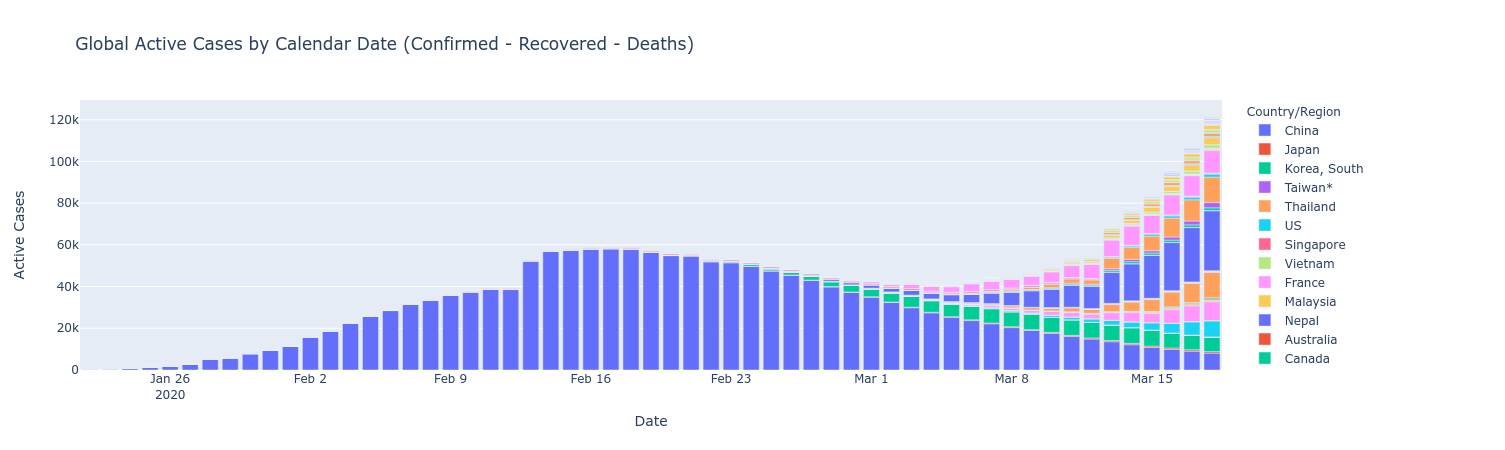

In [6]:
world_chart = px.bar(covid_19_national_observations, 
    x="Date", y="Active Cases", color="Country/Region", title="Global Active Cases by Calendar Date (Confirmed - Recovered - Deaths)")
world_chart.show()

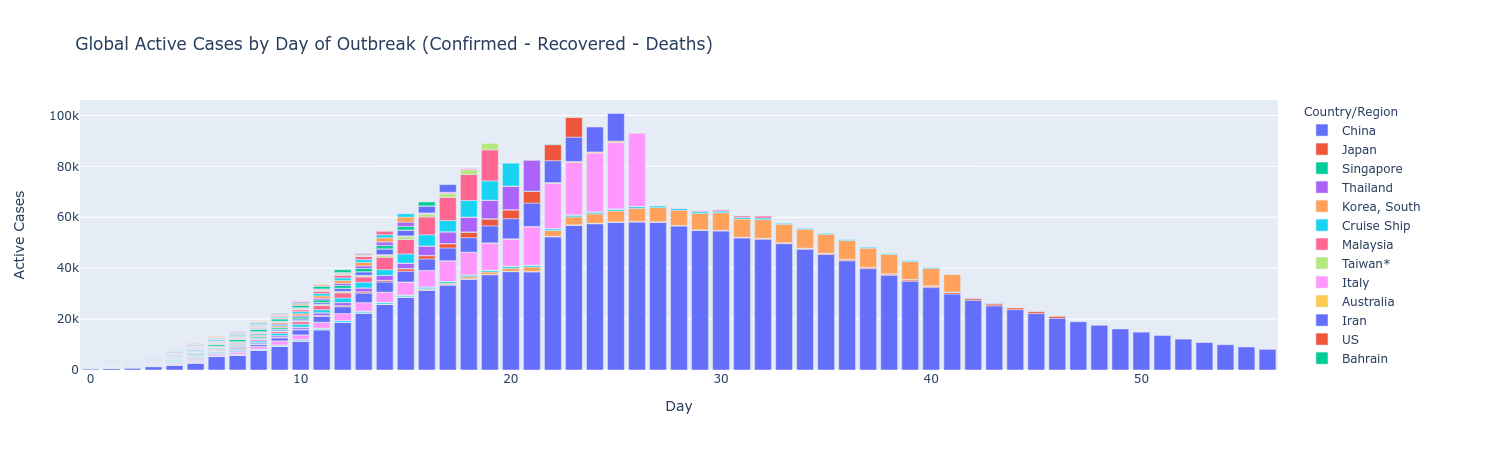

In [7]:
world_chart = px.bar(covid_19_infected_observations, 
    x="Day", y="Active Cases", color="Country/Region", title="Global Active Cases by Day of Outbreak (Confirmed - Recovered - Deaths)")
world_chart.show()

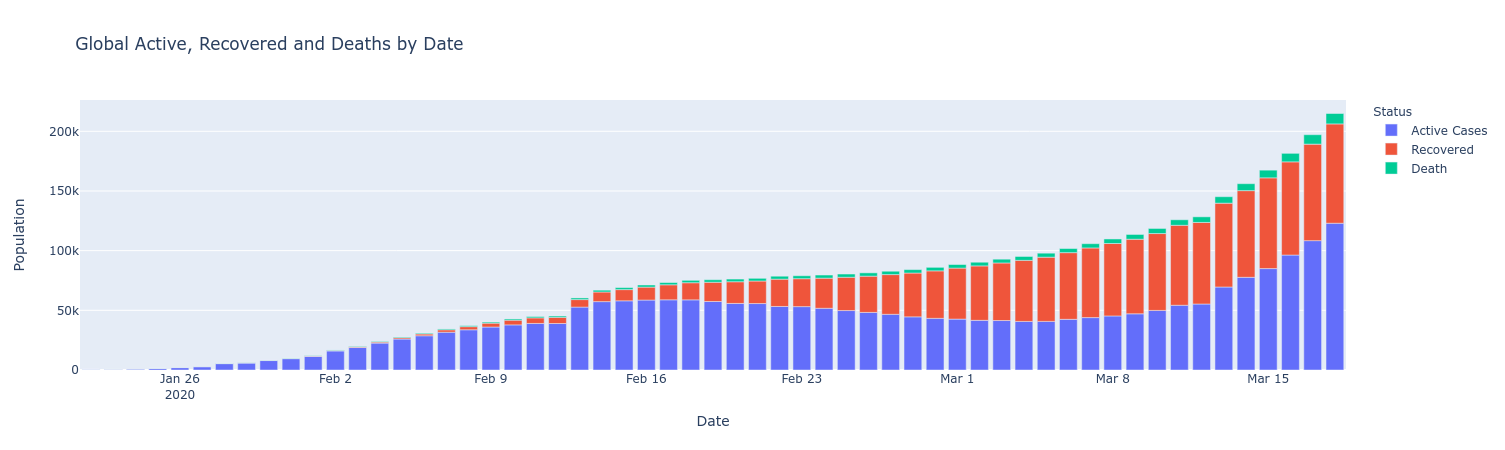

In [8]:
covid_19_world_totals_state = covid_19_world_totals[['Date', 'Active Cases', 'Recovered', 'Death']].melt(id_vars=['Date'], 
            value_vars=['Active Cases', 'Recovered', 'Death'], value_name="Population", var_name='Status')
world_chart = px.bar(covid_19_world_totals_state, 
    x="Date", y="Population", color="Status", title="Global Active, Recovered and Deaths by Date")
world_chart.show()

In [9]:
cn_df = covid_19_national_observations.copy()
cn_df = cn_df[cn_df['Country/Region'] == 'China']

In [10]:
cn_df['Death'].max() / (cn_df['Active Cases'].max() * 1.14) 

0.048925835618853705

In [11]:
countries = covid_19_national_observations.groupby('Country/Region')

In [12]:
#select a single from group
#countries.get_group('China')

/home/mprorock/devel/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning:

Ill-conditioned matrix (rcond=8.28128e-19): result may not be accurate.



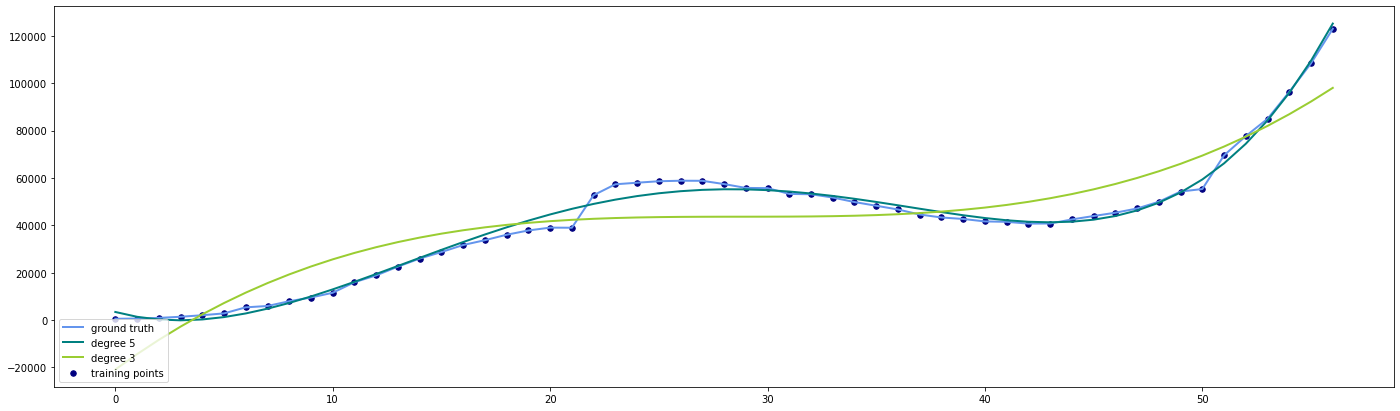

In [13]:
fDay=3

covid_19_world_totals=covid_19_world_totals.sort_values('Date')
covid_19_world_totals=covid_19_world_totals.reset_index(drop=True)
covid_19_world_totals['Day'] = covid_19_world_totals.index
x=covid_19_world_totals.index
y=covid_19_world_totals['Active Cases']

x_plot = x

# create matrix versions of these arrays
X = x[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

colors = ['teal', 'yellowgreen', 'gold']
lw = 2

plt.figure(figsize=(24,7))
plt.plot(x, y, color='cornflowerblue', linewidth=lw,
         label="ground truth")
plt.scatter(x, y, color='navy', s=30, marker='o', label="training points")

for count, degree in enumerate([5, 3]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(X, y)
    y_plot = model.predict(X_plot)
    plt.plot(x_plot, y_plot, color=colors[count], linewidth=lw,
             label="degree %d" % degree)

plt.legend(loc='lower left')

plt.show()

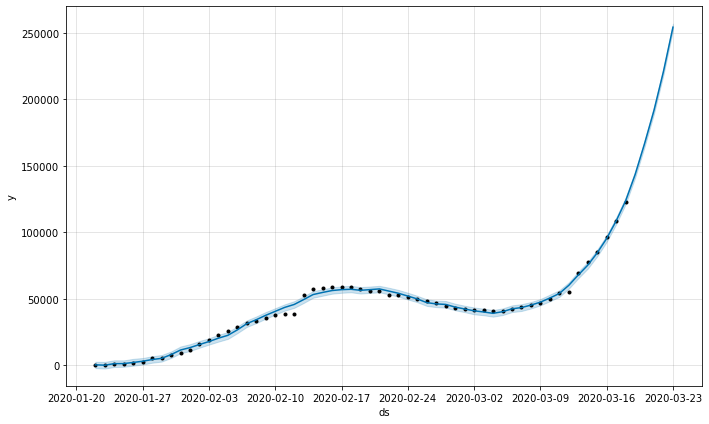

In [14]:
fb_df = covid_19_world_totals[['Date', 'Active Cases']].copy()
fb_df = fb_df.sort_values('Date').reset_index(drop=True)
fb_df.columns = ['ds','y']
#print(fb_df)

m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, growth='linear')
m.fit(fb_df)

future = m.make_future_dataframe(periods=5)

forecast = m.predict(future)

fig1 = m.plot(forecast)

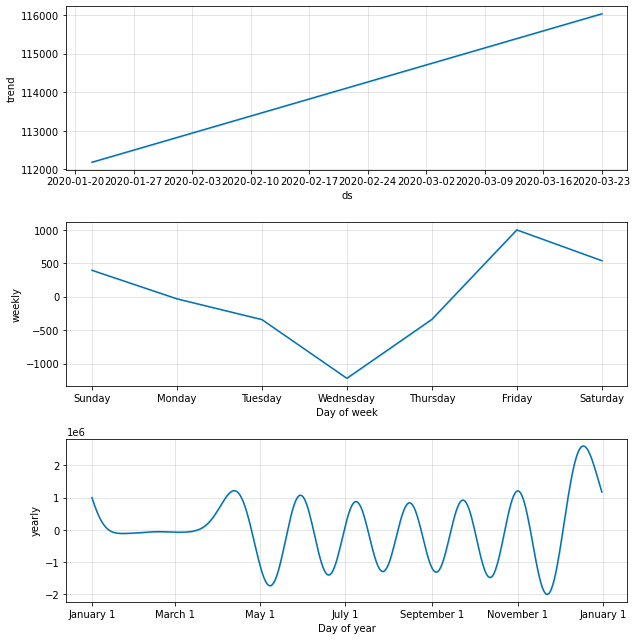

In [15]:
fig2 = m.plot_components(forecast)

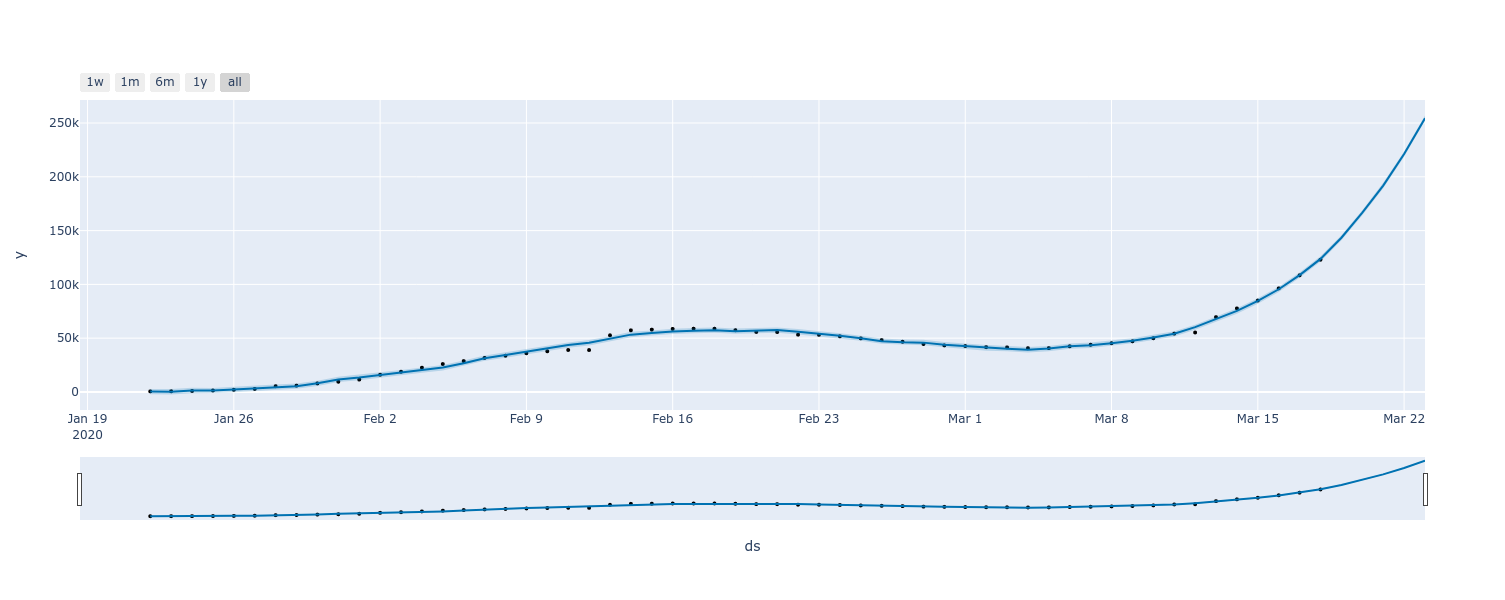

In [16]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)

In [20]:
#covid_19_infected_observations.groupby(['Country/Region', pd.qcut(covid_19_infected_observations['Active Cases'], 10)])
covid_19_infected_observations['Case Bins'] = pd.qcut(covid_19_infected_observations['Active Cases'], 10)

In [126]:
cluster_df = covid_19_infected_observations[['Day', 'Active Cases', 'Death', 'Recovered']]
cluster_df = MinMaxScaler().fit_transform(cluster_df)
db = DBSCAN(eps=0.001, min_samples=10).fit(cluster_df)
labels = db.labels_
covid_19_infected_observations['ClusterDB'] = labels

cluster_df = pd.DataFrame(cluster_df)
cluster_df.columns = ['Day', 'Active Cases', 'Death', 'Recovered']
covid_19_infected_observations['Active Score'] = cluster_df['Active Cases']
covid_19_infected_observations['Death Score'] = cluster_df['Death']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcd217002d0>]],
      dtype=object)

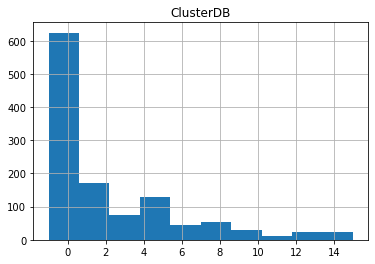

In [127]:
covid_19_infected_observations[['ClusterDB', 'Country/Region']].hist()

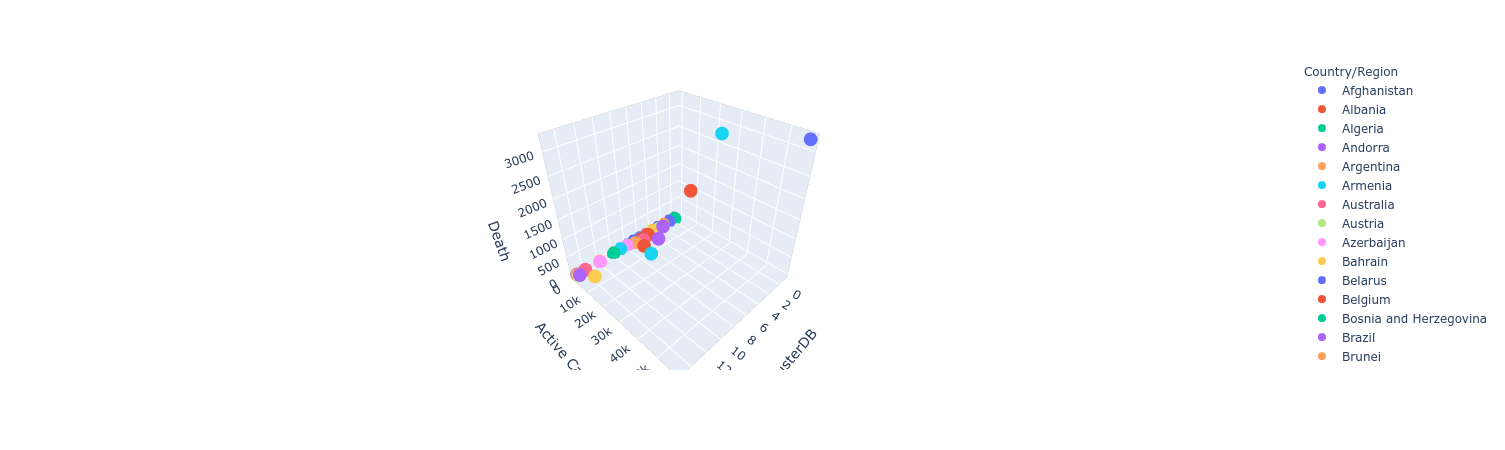

In [157]:
cluster_plot_df = covid_19_infected_observations[['Country/Region', 'ClusterDB', 'Active Cases', 'Death']].copy().groupby('Country/Region').max().reset_index()
cluster_plot_3d = px.scatter_3d(cluster_plot_df, x = 'ClusterDB', y='Active Cases', z='Death', color='Country/Region')
cluster_plot_3d.show()

In [134]:
cluster_groups = covid_19_infected_observations[['Country/Region', 'ClusterDB', 'Active Score', 'Death Score']].copy().groupby(['ClusterDB', 'Country/Region']).max().reset_index()

In [154]:
cluster_df = covid_19_infected_observations[['Day', 'Active Cases', 'Death', 'Recovered']]
cluster_km = KMeans(n_clusters=3)
cluster_km.fit(cluster_df)
labels = cluster_km.labels_
covid_19_infected_observations['ClusterK5'] = labels

In [155]:
cluster_plot_df = covid_19_infected_observations[['Country/Region', 'ClusterK5', 'ClusterDB', 'Active Cases', 'Death']].copy().groupby('Country/Region').max().reset_index()
cluster_plot_3d = px.scatter_3d(cluster_plot_df, x = 'ClusterK5', y='Active Cases', z='Death', color='Country/Region')
#cluster_plot_3d.show()

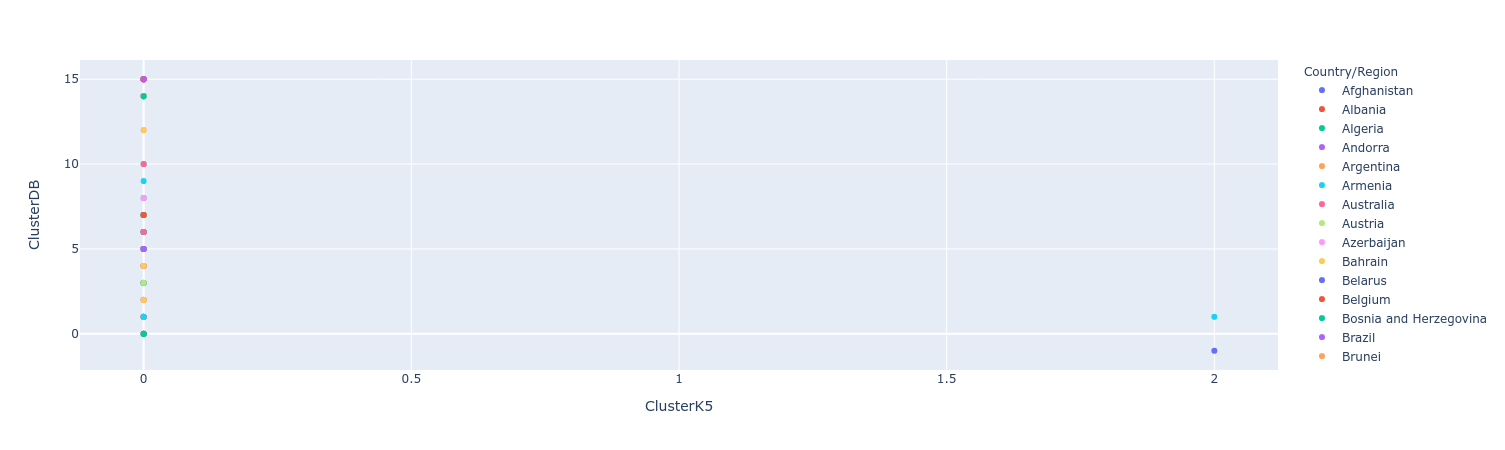

In [156]:
cluster_plot = px.scatter(cluster_plot_df, x='ClusterK5', y='ClusterDB', color='Country/Region')
cluster_plot.show()